<a href="https://colab.research.google.com/github/reitezuz/18NES1-2025-/blob/main/week3/linear_neuron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear neuron

##1. LSQ Algorithm
- and the SSE (The Sum squared error), SAE (The Sum absolute error), MSE (The Mean squared error), MAE (The Mean absolute error) functions



In [61]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import time

class LinearNeuron:
    def __init__(self, input_dim, init_method='zero'):
        # weight initialization:
        if init_method == 'random':
            self.weights = np.random.uniform(-1, 1, (input_dim, 1)) / 10  # Random initialization
            self.bias = float(np.random.uniform(-1, 1) / 10)
        elif init_method == 'widrow-hoff':
            self.weights = np.random.randn(input_dim, 1) * (2 / np.sqrt(input_dim))  # Widrow-Hoff rule
            self.bias = float(np.random.randn() * (2 / np.sqrt(input_dim)))
        else: # init_method == 'zero':
            self.weights = np.zeros((input_dim, 1))  # Initialize weights to zeros
            self.bias = 0.0
        self.epochs = -1

    def set_weights(self, weights, bias):
        self.weights = np.array(weights, dtype=float).reshape(-1, 1)
        self.bias = float(bias)

    def __str__(self):
        return f"LinearNeuron(weights={self.weights.T}, bias={self.bias})"

    def activation(self, x):
        return x

    def forward(self, inputs):
        potential = np.dot(inputs, self.weights) + self.bias
        #potential = inputs @ self.weights + self.bias
        return self.activation(potential).flatten()

    def LSQ(self, training_inputs, true_outputs):
        X_aug = np.hstack([training_inputs, np.ones((training_inputs.shape[0], 1))]) # extend input by ones

        weights_aug, _, _, _ = np.linalg.lstsq(X_aug, true_outputs, rcond=None)  # using library function

        self.weights = weights_aug[:-1].reshape(-1, 1)  # ensure column vector
        self.bias = float(weights_aug[-1].item())

    def LSQ_pseudoinverse(self, training_inputs, true_outputs):
        X_aug = np.hstack([training_inputs, np.ones((training_inputs.shape[0], 1))]) # extend input by ones

        weights_aug = np.linalg.pinv(X_aug.T @ X_aug) @ X_aug.T @ true_outputs       # Moore-Penrose pseudoinverse

        self.weights = weights_aug[:-1].reshape(-1, 1)  # Ensure column vector
        self.bias = float(weights_aug[-1].item())

    def LSQ_tichonov(self, training_inputs, true_outputs, lambda_reg=1e-5):
        X_aug = np.hstack([training_inputs, np.ones((training_inputs.shape[0], 1))]) # extend input by ones

        n = X_aug.shape[1]
        weights_aug = np.linalg.solve((X_aug.T @ X_aug) + np.eye(n) * lambda_reg, X_aug.T @ true_outputs)

        self.weights = weights_aug[:-1].reshape(-1, 1)  # Ensure column vector
        self.bias = float(weights_aug[-1].item())
    def gradient_descent_iterative(self, training_inputs, true_outputs, learning_rate=1, epochs=100, adaptive_learning_rate=True, min_error=0, print_progress=False):
        if print_progress:
            print("Gradient Descent iterative:")
        learning_rate_0 = learning_rate
        for epoch in range(epochs):

            # Shuffle the training data for each epoch
            shuffled_indices = np.random.permutation(len(training_inputs))
            training_inputs = training_inputs[shuffled_indices]
            true_outputs = true_outputs[shuffled_indices]

            if adaptive_learning_rate:
                learning_rate = learning_rate_0 / ((epoch + 1)**0.5)

            for inputs, true_output in zip(training_inputs, true_outputs):
                inputs = inputs.reshape(-1, 1)  # Ensure column vector
                prediction = self.forward(inputs.T)  # Ensure row vector for forward pass
                error = true_output - prediction
                self.weights += learning_rate * error * inputs  # Update weights correctly
                self.bias += float((learning_rate * error).item())  # Update bias
            mse = MSE_error(true_outputs, self.forward(training_inputs))

            if print_progress:
                print(f"Epoch: {epoch}, MSE: {mse:0.4f} Weights: {self.weights.T} Bias: {self.bias} Learning rate: {learning_rate:.4f}")

            if mse <= min_error:
                break
        if print_progress:
            print(f"The training ended after {epoch+1} epochs.")
        self.epochs = epoch+1

    def gradient_descent_batch(self, training_inputs, true_outputs, learning_rate=1, epochs=100, adaptive_learning_rate=True, min_error=0, print_progress=False):
        if print_progress:
            print("Gradient Descent batch:")

        training_inputs = np.array(training_inputs)  # (m, n)
        true_outputs = np.array(true_outputs).reshape(-1, 1)  # (m, 1)
        batch_size = training_inputs.shape[0]  # Scalar

        learning_rate_0 = learning_rate
        for epoch in range(epochs):
            if adaptive_learning_rate:
                learning_rate = learning_rate_0 / ((epoch + 1)**0.5)
            prediction = self.forward(training_inputs).reshape(-1, 1)  # (m, 1)
            errors = true_outputs - prediction  # (m, 1)
            weight_gradient = (training_inputs.T @ errors)   # (n, 1)
            bias_gradient = np.sum(errors)  # Scalar

            self.weights += learning_rate * weight_gradient  # (n, 1)
            self.bias += learning_rate * bias_gradient  # Scalar

            mse = MSE_error(true_outputs.flatten(), self.forward(training_inputs))  # (m,)

            if print_progress:
                print(f"Epoch: {epoch}, MSE: {mse:0.4f} Weights: {self.weights.T} Bias: {self.bias} Learning rate: {learning_rate:.4f}")

            if mse <= min_error:
                break
        if print_progress:
            print(f"The training ended after {epoch+1} epochs.")
        self.epochs = epoch + 1

def plot_regression_3D(perceptron, training_inputs, true_outputs):
    """Plots the data points and the regression plane in 3D."""

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot of the data points
    ax.scatter(training_inputs[:, 0], training_inputs[:, 1], true_outputs.flatten(),
               label="Data points", color='blue', alpha=0.4, s=50)

    # Create a meshgrid for the plane
    x_range = np.linspace(min(training_inputs[:, 0]), max(training_inputs[:, 0]), 20)
    y_range = np.linspace(min(training_inputs[:, 1]), max(training_inputs[:, 1]), 20)
    X, Y = np.meshgrid(x_range, y_range)

    # Calculate Z values for the plane using the perceptron's weights and bias
    Z = perceptron.weights[0] * X + perceptron.weights[1] * Y + perceptron.bias

    # Plot the regression plane
    ax.plot_surface(X, Y, Z, alpha=0.5, facecolors=plt.cm.Reds(Z), edgecolor='k', rstride=1, cstride=1)

    # Labels
    ax.set_xlabel("x_1")
    ax.set_ylabel("x_2")
    ax.set_zlabel("y")
    ax.set_title("3D Linear Regression Fit")

    plt.show()

def plot_decision_boundary_2D(perceptron, training_inputs, true_outputs):
    """Plots the decision boundary of the perceptron."""
    import matplotlib.pyplot as plt
    import numpy as np

    # Extract the first two columns of training_inputs
    x1 = training_inputs[:, 0]
    x2 = training_inputs[:, 1]

    # Generate points for visualization
    x_min, x_max = np.min(x1) - 1, np.max(x1) + 1  # Extend the range slightly
    y_min, y_max = np.min(x2) - 1, np.max(x2) + 1  # Extend the range slightly

    x = np.linspace(x_min, x_max, 100)
    weights = perceptron.weights.flatten()
    y = -(weights[0] * x + perceptron.bias) / weights[1]

    plt.figure(figsize=(5, 3))
    # Plot the decision boundary
    plt.plot(x, y, label='Decision Boundary')

    # Plot the points
    for i, input_vector in enumerate(training_inputs):
        if true_outputs[i] == 1:
            plt.scatter(input_vector[0], input_vector[1], color='green', label='Class 1' if i == 0 else "")  # Add label only for the first point of each class
        else:
            plt.scatter(input_vector[0], input_vector[1], color='red', label='Class -1' if i == 0 else "")

    plt.xlabel('x1', fontsize=12)
    plt.ylabel('x2', fontsize=12)
    plt.title('Perceptron Decision Boundary', fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)  # Set y-axis limits

    # Highlight x and y axes
    plt.axhline(0, color='black', linewidth=0.8)  # x-axis
    plt.axvline(0, color='black', linewidth=0.8)  # y-axis
    plt.show()

def plot_regression(perceptron, training_inputs, true_outputs):
    """Plots the data points and the regression line."""
    plt.figure(figsize=(5, 3))

    # Plot the data points
    plt.scatter(training_inputs, true_outputs, label="Data points", color='blue', alpha=0.6)

    # Generate predictions for the regression line
    X_test = np.linspace(-1, 1, 100).reshape(-1, 1)
    d_pred = perceptron.weights * X_test + perceptron.bias

    plt.plot(X_test, d_pred, label="Regression line", color='red', linewidth=2)
    plt.xlabel("x_1")
    plt.ylabel("y")
    plt.legend()
    plt.title("Linear Regression Fit")
    plt.show()

def sign(x):
    return np.where(x > 0, 1, np.where(x < 0, -1, 0))

def perceptron_error(true_outputs, predicted_outputs):
    return np.sum(true_outputs != predicted_outputs)

def SSE_error(true_outputs, predicted_outputs):
    # The Sum squared error
    return np.sum((true_outputs - predicted_outputs) ** 2)
def SAE_error(true_outputs, predicted_outputs):
    # The Sum absolute error
    return np.sum(np.abs(true_outputs - predicted_outputs))
def MAE_error(true_outputs, predicted_outputs):
    # The Mean absolute error
    return np.mean(np.abs(true_outputs - predicted_outputs))
def MSE_error(true_outputs, predicted_outputs):
    # The Mean squared error
    return np.mean((true_outputs - predicted_outputs) ** 2)

def run_example_LSQ(experiment_results, inputs, true_outputs, init_method, variant, data_description):
    times = []
    errors = []
    epoch_counts = []

    start_time = time.time()
    perceptron = LinearNeuron(inputs.shape[1], init_method)
    if variant == 'pseudoinverse':
        perceptron.LSQ_pseudoinverse(inputs, true_outputs)
    elif variant == 'tichonov':
        perceptron.LSQ_tichonov(inputs, true_outputs)
    elif variant == 'library':
        perceptron.LSQ(inputs, true_outputs)
    elif variant == 'gradient':
        perceptron.gradient_descent_iterative(inputs, true_outputs)
    elif variant == 'batch':
        perceptron.gradient_descent_batch(inputs, true_outputs)
    end_time = time.time()
    elapsed_time = end_time - start_time

    real_outputs = perceptron.forward(inputs)
    error_MSE = MSE_error(true_outputs, real_outputs)
    error_SSE = SSE_error(true_outputs, real_outputs)

    results = {
        'MSE': error_MSE,
        'SSE': error_SSE,
        'Time': elapsed_time,
        'Variant': variant,
        'Weights': perceptron.weights,
        'Bias': perceptron.bias,
        'Data Description': data_description
    }
    experiment_results.loc[len(experiment_results)] = results

### Example 1
- train the linear neuron on the given data:
- you can change the training data ant the variant of LSQ:
- observe carefully the predicted values

LinearNeuron(weights=[[-0.5 -0.5]], bias=0.5)
LSQ: pseudoinverse
Perceptron error: 4
SSE error: 1.0
MSE error: 0.25
SAE error: 2.0
MAE error: 0.5


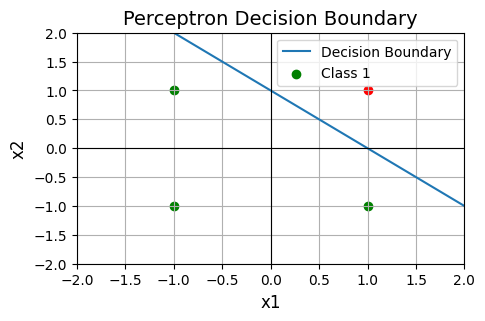

,Input,Predicted,True
0,"[-1, -1]",[1.5],1
1,"[-1, 1]",[0.5],1
2,"[1, -1]",[0.5],1
3,"[1, 1]",[-0.5],-1


In [62]:
# Example 1 from the presentation:
# Data:
inputs = np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])
true_outputs = np.array([1, 1, 1, -1])
#variant = "tichonov"
variant = "pseudoinverse"
#variant = "library"

# Linear Neuron parameters:
init_method = 'random'

# Train the linear neuron:
perceptron = LinearNeuron(inputs.shape[1], init_method)
if variant == "library":
    perceptron.LSQ(inputs, true_outputs)
elif variant == "pseudoinverse":
    perceptron.LSQ_pseudoinverse(inputs, true_outputs)
elif variant == "tichonov":
    perceptron.LSQ_tichonov(inputs, true_outputs)

# Print summary:
print(perceptron)
print("LSQ:", variant)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
print(f"Perceptron error: {perceptron_error(true_outputs, real_outputs)}")
print(f"SSE error: {SSE_error(true_outputs, real_outputs)}")
print(f"MSE error: {MSE_error(true_outputs, real_outputs)}")
print(f"SAE error: {SAE_error(true_outputs, real_outputs)}")
print(f"MAE error: {MAE_error(true_outputs, real_outputs)}")
plot_decision_boundary_2D(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}

df


- comparison of LSQ variants:

In [63]:
# Example 1
# Data and parameters:
inputs = np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])
true_outputs = np.array([1, 1, 1, -1])
data_description = "Ex. 1"
init_method = 'zero'

# Run experiment:
experiment_results_1 = pd.DataFrame(columns=['MSE', 'SSE', 'Time', 'Variant', 'Weights', 'Bias', 'Data Description'])
for variant in ['library', 'pseudoinverse', 'tichonov', 'gradient', 'batch']:
    run_example_LSQ(experiment_results_1, inputs, true_outputs, init_method, variant, data_description)
print("\nExperiment Results:")
experiment_results_1


Experiment Results:


,MSE,SSE,Time,Variant,Weights,Bias,Data Description
0,0.250000,1.000000,0.000277,library,"[[-0.5], [-0.49999999999999994]]",0.500000,Ex. 1
1,0.250000,1.000000,0.000323,pseudoinverse,"[[-0.5], [-0.5]]",0.500000,Ex. 1
2,0.250000,1.000000,0.000152,tichonov,"[[-0.49999875000312505], [-0.49999875000312505]]",0.499999,Ex. 1
3,0.250545,1.002178,0.011912,gradient,"[[-0.48085260209309416], [-0.5110726987043182]]",0.507438,Ex. 1
4,0.250000,1.000000,0.005463,batch,"[[-0.49999999999999994], [-0.5]]",0.500000,Ex. 1


### Example 2
- train the linear neuron on the given data:
- you can change the training data ant the variant of LSQ:

LinearNeuron(weights=[[ 0.       -0.999995]], bias=0.0)
LSQ: tichonov
Perceptron error: 2
SSE error: 4.999950000408418e-11
MSE error: 2.499975000204209e-11
SAE error: 9.99995000028342e-06
MAE error: 4.99997500014171e-06


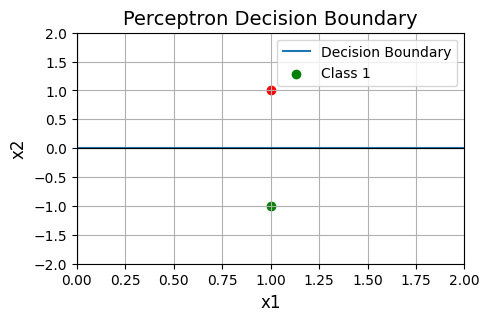

,Input,Predicted,True
0,"[1, -1]",[0.9999950000249999],1
1,"[1, 1]",[-0.9999950000249999],-1


In [64]:
# Example 2 from the presentation:
# Data:
inputs = np.array([[1, -1], [1, 1]])
true_outputs = np.array([1, -1])
#variant = "library"
#variant = "pseudoinverse"
variant = "tichonov"

# Linear Neuron parameters:
init_method = 'random'

# Train the linear neuron:
perceptron = LinearNeuron(inputs.shape[1], init_method)
if variant == "library":
    perceptron.LSQ(inputs, true_outputs)
elif variant == "pseudoinverse":
    perceptron.LSQ_pseudoinverse(inputs, true_outputs)
elif variant == "tichonov":
    perceptron.LSQ_tichonov(inputs, true_outputs)

# Print summary:
print(perceptron)
print("LSQ:", variant)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
print(f"Perceptron error: {perceptron_error(true_outputs, real_outputs)}")
print(f"SSE error: {SSE_error(true_outputs, real_outputs)}")
print(f"MSE error: {MSE_error(true_outputs, real_outputs)}")
print(f"SAE error: {SAE_error(true_outputs, real_outputs)}")
print(f"MAE error: {MAE_error(true_outputs, real_outputs)}")
plot_decision_boundary_2D(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}

df


-comparison of LSQ variants:

In [65]:
# Example 2 from the presentation:
# Data and parameters:
inputs = np.array([[1, -1], [1, 1]])
true_outputs = np.array([1, -1])
data_description = "Ex. 2"
init_method = 'zero'

# Run experiment:
experiment_results_1 = pd.DataFrame(columns=['MSE', 'SSE', 'Time', 'Variant', 'Weights', 'Bias', 'Data Description'])
for variant in ['library', 'pseudoinverse', 'tichonov', 'gradient', 'batch']:
    run_example_LSQ(experiment_results_1, inputs, true_outputs, init_method, variant, data_description)
print("\nExperiment Results:")
experiment_results_1 #.round(5)




Experiment Results:


,MSE,SSE,Time,Variant,Weights,Bias,Data Description
0,3.204747e-31,6.409495e-31,0.000254,library,"[[-3.3306690738754696e-16], [-1.00000000000000...",-2.775558e-16,Ex. 2
1,0.000000e+00,0.000000e+00,0.000318,pseudoinverse,"[[0.0], [-1.0]]",0.000000e+00,Ex. 2
2,2.499975e-11,4.999950e-11,0.000170,tichonov,"[[0.0], [-0.9999950000249999]]",0.000000e+00,Ex. 2
3,4.437343e-31,8.874685e-31,0.006796,gradient,"[[9.83288148044814e-18], [-1.0000000000000007]]",9.832881e-18,Ex. 2
4,0.000000e+00,0.000000e+00,0.000448,batch,"[[0.0], [-1.0]]",0.000000e+00,Ex. 2


### Example: XOR

LinearNeuron(weights=[[0. 0.]], bias=0.0)
LSQ: pseudoinverse
Perceptron error: 4
SSE error: 4.0
MSE error: 1.0
SAE error: 4.0
MAE error: 1.0


<ipython-input-61-b1116fbba740>:166: RuntimeWarning: invalid value encountered in divide
  y = -(weights[0] * x + perceptron.bias) / weights[1]


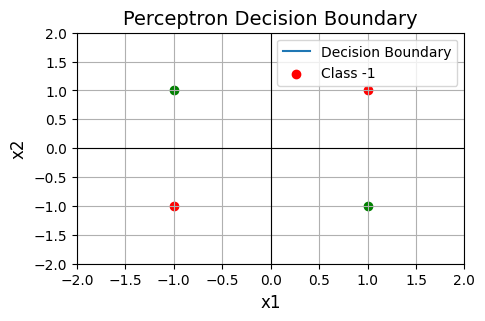

,Input,Predicted,True
0,"[-1, -1]",[0.0],-1
1,"[-1, 1]",[0.0],1
2,"[1, -1]",[0.0],1
3,"[1, 1]",[0.0],-1


In [66]:
# Example XOR:
# Data:
inputs = np.array([ [-1, -1],
                    [-1,  1],
                    [ 1, -1],
                    [ 1,  1]])
true_outputs = np.array([-1, 1, 1, -1])
#variant = "library"
variant = "pseudoinverse"
#variant = "tichonov"

# Linear Neuron parameters:
init_method = 'random'

# Train the linear neuron:
perceptron = LinearNeuron(inputs.shape[1], init_method)
if variant == "library":
    perceptron.LSQ(inputs, true_outputs)
elif variant == "pseudoinverse":
    perceptron.LSQ_pseudoinverse(inputs, true_outputs)
elif variant == "tichonov":
    perceptron.LSQ_tichonov(inputs, true_outputs)

# Print summary:
print(perceptron)
print("LSQ:", variant)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
print(f"Perceptron error: {perceptron_error(true_outputs, real_outputs)}")
print(f"SSE error: {SSE_error(true_outputs, real_outputs)}")
print(f"MSE error: {MSE_error(true_outputs, real_outputs)}")
print(f"SAE error: {SAE_error(true_outputs, real_outputs)}")
print(f"MAE error: {MAE_error(true_outputs, real_outputs)}")
plot_decision_boundary_2D(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}

df

### Example 3: Linear regression


- create the data:

In [67]:
def generate_regression_data_1D(A=1.5, B=3, std_noise=0.3, number_of_samples=100):
    # y = A x1 + C + noise

    inputs = np.random.uniform(-1, 1, size=(number_of_samples, 1))  # Random values between -1 and 1
    true_outputs = 1.5 * inputs[:, [0]] + 3 + np.random.randn(number_of_samples, 1) * std_noise  # Gaussian noise

    # Define true function with noise
    noise = np.random.normal(0, std_noise, size=inputs.shape)  # Gaussian noise
    true_outputs = A * inputs[:, [0]]  + B + noise
    return inputs, true_outputs

inputs, true_outputs = generate_regression_data_1D()

- train the linear neuron on the data
- you can change the true outputs and the level of additive noise in the data


LinearNeuron(weights=[[1.5049593]], bias=2.9994651898437876)
LSQ: pseudoinverse
Perceptron error: 10000
MSE error: 1.7002315283768377
MAE error: 1.064306620809108


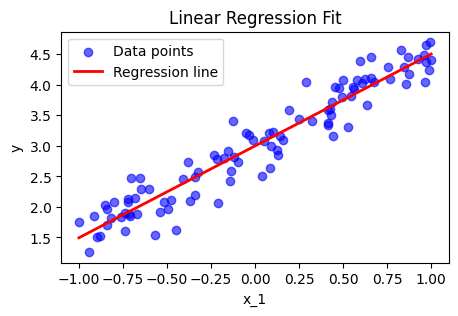

,Input,Predicted,True
0,[0.052212442800424474],[3.0780427912473347],[3.076151143841351]
1,[0.9671305734440672],[4.454957341317193],[4.050966702695704]
2,[-0.5698555410918924],[2.141855793235411],[1.5332598914120639]
3,[0.6761183900760213],[4.016995849347229],[4.050662810623491]
4,[-0.4105533783979558],[2.381599064599558],[2.4595238929154895]
...,...,...,...
95,[0.09958606318549523],[3.1493381618525724],[3.2285183231960564]
96,[0.7661338087642551],[4.15246539090639],[4.090010333519292]
97,[-0.7129458062600356],[1.9265107678343238],[1.8840514847620105]
98,[0.4534151553496739],[3.681836544955034],[3.961799493520406]


In [68]:
# Example: simple linear regression
# Data and parameters:
inputs, true_outputs = generate_regression_data_1D(A=1.5, B=3, std_noise=0.3, number_of_samples=100)

#variant = "library"
variant = "pseudoinverse"
#variant = "tichonov"
init_method = 'random'

# Train the linear neuron:
perceptron = LinearNeuron(inputs.shape[1], init_method)
if variant == "library":
    perceptron.LSQ(inputs, true_outputs)
elif variant == "pseudoinverse":
    perceptron.LSQ_pseudoinverse(inputs, true_outputs)
elif variant == "tichonov":
    perceptron.LSQ_tichonov(inputs, true_outputs)

# Print summary:
print(perceptron)
print("LSQ:", variant)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
print(f"Perceptron error: {perceptron_error(true_outputs, real_outputs)}")
#print(f"SSE error: {SSE_error(true_outputs, real_outputs)}")
print(f"MSE error: {MSE_error(true_outputs, real_outputs)}")
#print(f"SAE error: {SAE_error(true_outputs, real_outputs)}")
print(f"MAE error: {MAE_error(true_outputs, real_outputs)}")
plot_regression(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}

df

- comparison of LSQ variants:

In [69]:

# Data and parameters:
inputs, true_outputs = generate_regression_data_1D(A=1.5, B=3, std_noise=0.3, number_of_samples=100)
data_description = "Lin. regr. 1"
init_method = 'random'

# Run experiment:
experiment_results_1 = pd.DataFrame(columns=['MSE', 'SSE', 'Time', 'Variant', 'Weights', 'Bias', 'Data Description'])
for variant in ['library', 'pseudoinverse', 'tichonov', 'gradient', 'batch']:
    run_example_LSQ(experiment_results_1, inputs, true_outputs, init_method, variant, data_description)
print("\nExperiment Results:")
experiment_results_1


Experiment Results:


/usr/local/lib/python3.11/dist-packages/pandas/core/nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


,MSE,SSE,Time,Variant,Weights,Bias,Data Description
0,1.515032e+00,1.515032e+04,0.000298,library,[[1.5192478457709593]],2.952686e+00,Lin. regr. 1
1,1.515032e+00,1.515032e+04,0.000299,pseudoinverse,[[1.519247845770961]],2.952686e+00,Lin. regr. 1
2,1.515031e+00,1.515031e+04,0.000153,tichonov,[[1.5192472562957904]],2.952685e+00,Lin. regr. 1
3,1.556227e+00,1.556227e+04,0.135752,gradient,[[1.5521761201306026]],3.057098e+00,Lin. regr. 1
4,1.112992e+238,1.112992e+242,0.003853,batch,[[1.4327294448924817e+118]],-1.038202e+119,Lin. regr. 1


- observe how the level of noise in the data affects the training and error

In [70]:
# Data and parameters
data_description = "Lin. regr. 1"
init_method = 'zero'
variant = 'pseudoinverse'

# Run experiment:
experiment_results_1 = pd.DataFrame(columns=['MSE', 'SSE', 'Time', 'Variant', 'Weights', 'Bias', 'Data Description'])
for std_noise in [0.01, 0.1, 1, 10]:
    np.random.seed(42)
    inputs, true_outputs = generate_regression_data_1D(A=1.5, B=3, std_noise=std_noise, number_of_samples=100)
    run_example_LSQ(experiment_results_1, inputs, true_outputs, init_method, variant, data_description)
print("\nExperiment Results:")
experiment_results_1 #.round(5)


Experiment Results:


,MSE,SSE,Time,Variant,Weights,Bias,Data Description
0,1.577292,1.577292e+04,0.000297,pseudoinverse,[[1.500049531226297]],3.000372,Lin. regr. 1
1,1.590032,1.590032e+04,0.000310,pseudoinverse,[[1.5004953122629763]],3.003717,Lin. regr. 1
2,2.779657,2.779657e+04,0.000273,pseudoinverse,[[1.5049531226297659]],3.037169,Lin. regr. 1
3,120.898450,1.208984e+06,0.000274,pseudoinverse,[[1.5495312262976673]],3.371689,Lin. regr. 1


### Example 4 - Linear regression with two input dimensions

- create and observe the data:

In [71]:
def generate_regression_data_2D(A=2, B=3, C=-4, std_noise=0.3, number_of_samples=100):
    # y = A x1 + B x2 + C + noise

    # Generate x1 and x2 from a uniform distribution (more variation than linspace)
    x1 = np.random.uniform(-1, 1, number_of_samples).reshape(-1, 1)
    x2 = np.random.uniform(-1, 1, number_of_samples).reshape(-1, 1)
    x2 = x2[np.random.permutation(number_of_samples)]  # Randomly shuffle x2
    inputs = np.hstack([x1, x2])

    # Define true function with noise
    noise = np.random.normal(0, std_noise, size=x1.shape)  # Gaussian noise
    true_outputs = A*x1 + B*x2 + C + noise
    return inputs, true_outputs

inputs, true_outputs = generate_regression_data_2D()

- train the linear neuron on the data
- you can change the true outputs and the level of additive noise in the data





LinearNeuron(weights=[[1.99205316 2.56079854]], bias=-3.780611991064234)
LSQ: pseudoinverse
Perceptron error: 10000
MSE error: 10.169711067524903
MAE error: 2.5344675577029108


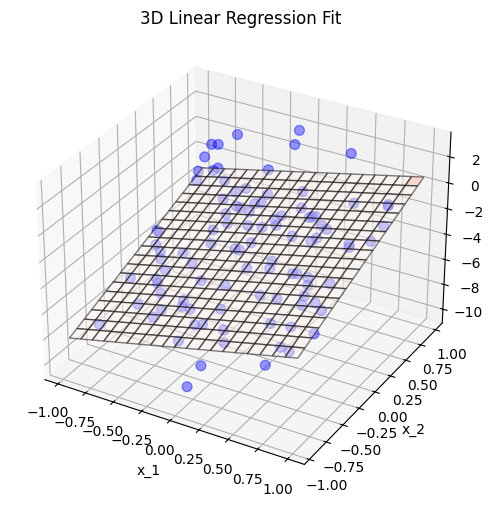

(100, 2)


,Input,Predicted,True
0,"[0.9953852318476866, -0.1948999128060389]",[-2.2968511078533167],[0.7757101785998475]
1,"[0.5048062400776454, 0.7221360399494432]",[-0.9257662089629508],[2.4195358871601806]
2,"[0.41396092248691807, -0.005070212040218847]",[-2.9689636193601623],[-0.9316521076738415]
3,"[0.5571438781015021, 0.20639480435395918]",[-2.142216255043649],[-7.296322838744547]
4,"[-0.7137440289030608, 0.4718092263920046]",[-3.994219660277839],[-1.4648428905739053]
...,...,...,...
95,"[-0.06353634311724132, 0.13888703552700066]",[-3.55151804624448],[-5.284202949776191]
96,"[0.24995197410210457, -0.7178363024445729]",[-5.120928526888324],[-5.166472906124892]
97,"[-0.2445481051196614, 0.6613090131304995]",[-2.574285660920501],[-2.901855280124415]
98,"[0.6731296265846658, -0.27388157560981896]",[-3.1410575310966626],[-3.579439206891413]


In [72]:
# Define parameters
inputs, true_outputs = generate_regression_data_2D(A=2, B=3, C=-4, std_noise=2.5, number_of_samples=100)

# Train the linear neuron:
perceptron = LinearNeuron(inputs.shape[1], init_method)
if variant == "library":
    perceptron.LSQ(inputs, true_outputs)
elif variant == "pseudoinverse":
    perceptron.LSQ_pseudoinverse(inputs, true_outputs)
elif variant == "tichonov":
    perceptron.LSQ_tichonov(inputs, true_outputs)

# Print summary:
print(perceptron)
print("LSQ:", variant)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
print(f"Perceptron error: {perceptron_error(true_outputs, real_outputs)}")
#print(f"SSE error: {SSE_error(true_outputs, real_outputs)}")
print(f"MSE error: {MSE_error(true_outputs, real_outputs)}")
#print(f"SAE error: {SAE_error(true_outputs, real_outputs)}")
print(f"MAE error: {MAE_error(true_outputs, real_outputs)}")
plot_regression_3D(perceptron, inputs, true_outputs)
print(np.shape(inputs))

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}

df


- comparison:

In [73]:
# Data and parameters
data_description = "Lin. regr. 2"
init_method = 'zero'
variant = 'pseudoinverse'

# Run experiment:
experiment_results_1 = pd.DataFrame(columns=['MSE', 'SSE', 'Time', 'Variant', 'Weights', 'Bias', 'Data Description'])
for std_noise in [0.01, 0.1, 1, 2]:
    np.random.seed(42)
    inputs, true_outputs = generate_regression_data_2D(A=2, B=3, C = -4, std_noise=std_noise, number_of_samples=100)
    run_example_LSQ(experiment_results_1, inputs, true_outputs, init_method, variant, data_description)
print("\nExperiment Results:")
experiment_results_1 #.round(5)


Experiment Results:


,MSE,SSE,Time,Variant,Weights,Bias,Data Description
0,9.469434,94694.337416,0.000275,pseudoinverse,"[[2.0033162865773786], [2.995430899968277]]",-3.999275,Lin. regr. 2
1,9.398240,93982.402026,0.000223,pseudoinverse,"[[2.0331628657738046], [2.954308999682752]]",-3.992748,Lin. regr. 2
2,9.797116,97971.159983,0.000165,pseudoinverse,"[[2.3316286577380607], [2.543089996827503]]",-3.927485,Lin. regr. 2
3,12.609044,126090.444963,0.000155,pseudoinverse,"[[2.6632573154761228], [2.0861799936550036]]",-3.854970,Lin. regr. 2


##2. Iterative and batch gradient descent algorithm:


In [74]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import time



def run_example_multiple_times(experiment_results, inputs, true_outputs, epochs, init_method, learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, batch_size, num_runs=10):
    times = []
    mse_errors = []
    mae_errors = []
    epoch_counts = []

    for _ in range(num_runs):

        start_time = time.time()
        neuron = LinearNeuron(inputs.shape[1], init_method)

        if variant == 'iterative':
            neuron.gradient_descent_iterative(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, print_progress)
        elif variant == 'batch':
            neuron.gradient_descent_batch(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, print_progress)
        elif variant == 'pseudoinverse':
            neuron.LSQ_pseudoinverse(inputs, true_outputs)
        elif variant == 'tichonov':
            neuron.LSQ_tichonov(inputs, true_outputs)
        else:
            neuron.LSQ(inputs, true_outputs)

        end_time = time.time()
        elapsed_time = end_time - start_time

        real_outputs = neuron.forward(inputs)
        mse = MSE_error(true_outputs, real_outputs)
        mae = MAE_error(true_outputs, real_outputs)

        times.append(elapsed_time)
        mse_errors.append(mse)
        mae_errors.append(mae)
        epoch_counts.append(neuron.epochs)

    avg_time = np.mean(times)
    avg_mse = np.mean(mse_errors)
    avg_mae = np.mean(mae_errors)
    avg_epochs = np.mean(epoch_counts)

    results = {
        'Epochs': avg_epochs,
        'MSE': avg_mse,
        'MAE': avg_mae,
        'Time': avg_time,
        'Variant': variant,
        'Learning Rate': learning_rate,
        'Max Epochs': epochs,
        'Weights': neuron.weights,  # Note: Weights and bias are from the last run.
        'Bias': neuron.bias,
        'Data Description': data_description
    } #experiment_results_r = pd.DataFrame(columns=['MSE', 'SSE', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])

    experiment_results.loc[len(experiment_results)] = results

### Example 1
- observe the training process:
- experiment with the learning rate

Gradient Descent iterative:
Epoch: 0, MSE: 0.8326 Weights: [[-0.08422412  0.01607861]] Bias: 0.12135673587217784 Learning rate: 0.0300
Epoch: 1, MSE: 0.7024 Weights: [[-0.13246142 -0.04561085]] Bias: 0.167047707965599 Learning rate: 0.0300
Epoch: 2, MSE: 0.6021 Weights: [[-0.17535075 -0.10026523]] Bias: 0.20517836506400064 Learning rate: 0.0300
Epoch: 3, MSE: 0.5235 Weights: [[-0.2142668  -0.14660205]] Bias: 0.24130394261374566 Learning rate: 0.0300
Epoch: 4, MSE: 0.4623 Weights: [[-0.24943168 -0.18746144]] Bias: 0.2724083761075829 Learning rate: 0.0300
Epoch: 5, MSE: 0.4137 Weights: [[-0.2784764  -0.22664871]] Bias: 0.30021959350385097 Learning rate: 0.0300
Epoch: 6, MSE: 0.3784 Weights: [[-0.30229398 -0.25931809]] Bias: 0.3228941504354638 Learning rate: 0.0300
Epoch: 7, MSE: 0.3496 Weights: [[-0.32474478 -0.28810354]] Bias: 0.3452539965733207 Learning rate: 0.0300
Epoch: 8, MSE: 0.3276 Weights: [[-0.34386815 -0.31408666]] Bias: 0.3632664792245274 Learning rate: 0.0300
Epoch: 9, MSE: 

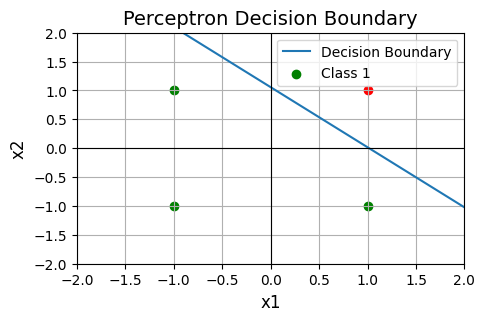

,Input,Predicted,True
0,"[-1, -1]",[1.2722854915984214],1
1,"[-1, 1]",[0.4506987950236194],1
2,"[1, -1]",[0.41773270004513785],1
3,"[1, 1]",[-0.40385399652966414],-1


In [75]:
# Example 1 from the presentation:
# Data and parameters:
inputs = np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])
true_outputs = np.array([1, 1, 1, -1])

print_progress = True
learning_rate = 0.03
init_method = 'random'
adaptive_learning_rate = False
min_error = 0.0001
epochs = 15

# Train the linear neuron:
perceptron = LinearNeuron(inputs.shape[1], init_method)
perceptron.gradient_descent_iterative(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, print_progress)

# Print summary:
print(perceptron)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
error = perceptron_error(true_outputs, real_outputs)
print(f"Perceptron error: {error}")
print(f"MAE error: {MAE_error(true_outputs, real_outputs)}")
print(f"MSE error: {MSE_error(true_outputs, real_outputs)}")
plot_decision_boundary_2D(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}

df


- finetune parameters (number of epochs, learning rate)

In [76]:
# DataFrame to store the results for comparisons:
experiment_results_r = pd.DataFrame(columns=['MSE', 'MAE', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])
#np.random.seed(42)  # For reproducibility
inputs = np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])
true_outputs = np.array([1, 1, 1, -1])
data_description_orig = "Ex. 1"
variant = "iterative"

# Perceptron parameters:
adaptive_learning_rate = False
batch_size = 4
min_error = 0.0001
epochs = 100
learning_rate = 0.1
init_method = 'random'
print_progress = False
data_description = data_description_orig + " " + ("adaptive " if adaptive_learning_rate else "non-adaptive ") + str(min_error) + (str(batch_size) if variant == "batch" else "")

for learning_rate in [0.01, 0.1 , 1]:
    run_example_multiple_times(experiment_results_r, inputs, true_outputs, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, batch_size)

learning_rate = 0.1
for epochs in [2, 5, 10, 20]:
    run_example_multiple_times(experiment_results_r, inputs, true_outputs, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, batch_size)


print("\nExperiment Results:")
experiment_results_r


Experiment Results:


,MSE,MAE,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,2.502310e-01,5.000000e-01,100.0,0.008289,iterative,0.01,100,"[[-0.4914438080609323], [-0.4928691337005592]]",4.922753e-01,Ex. 1 non-adaptive 0.0001
1,2.507029e-01,5.000000e-01,100.0,0.008303,iterative,0.10,100,"[[-0.5044684573658201], [-0.4863291413602032]]",5.088929e-01,Ex. 1 non-adaptive 0.0001
2,7.568523e+105,3.342420e+52,100.0,0.008466,iterative,1.00,100,"[[2.072439993745895e+50], [-3.774598422272479e...",1.537802e+50,Ex. 1 non-adaptive 0.0001
3,3.670229e-01,5.429055e-01,2.0,0.000194,iterative,0.10,2,"[[-0.36994477350775534], [-0.2636916534758979]]",2.933846e-01,Ex. 1 non-adaptive 0.0001
4,2.567116e-01,5.000000e-01,5.0,0.000439,iterative,0.10,5,"[[-0.4370315031127268], [-0.446818666825944]]",4.508118e-01,Ex. 1 non-adaptive 0.0001
5,2.512454e-01,5.000000e-01,10.0,0.000843,iterative,0.10,10,"[[-0.4718692426991517], [-0.528370482477878]]",5.065036e-01,Ex. 1 non-adaptive 0.0001
6,2.509732e-01,5.000000e-01,20.0,0.001729,iterative,0.10,20,"[[-0.5074034749450996], [-0.5180181888351312]]",4.904714e-01,Ex. 1 non-adaptive 0.0001


### Example 2
- observe the training process:
- experiment with the learning rate

Gradient Descent iterative:
Epoch: 0, MSE: 0.6001 Weights: [[-0.00798311 -0.22931044]] Bias: 0.08620021346744844 Learning rate: 0.1000
Epoch: 1, MSE: 0.3738 Weights: [[-0.01513746 -0.39193742]] Bias: 0.07904585894473223 Learning rate: 0.1000
Epoch: 2, MSE: 0.2328 Weights: [[-0.02119943 -0.52026964]] Bias: 0.07298388934515926 Learning rate: 0.1000
Epoch: 3, MSE: 0.1445 Weights: [[-0.03583578 -0.62049517]] Bias: 0.05834753876740227 Learning rate: 0.1000
Epoch: 4, MSE: 0.0901 Weights: [[-0.04390806 -0.69996607]] Bias: 0.0502752567150457 Learning rate: 0.1000
Epoch: 5, MSE: 0.0563 Weights: [[-0.04211749 -0.76303687]] Bias: 0.052065829427629884 Learning rate: 0.1000
Epoch: 6, MSE: 0.0351 Weights: [[-0.04637731 -0.81269964]] Bias: 0.04780601386083584 Learning rate: 0.1000
Epoch: 7, MSE: 0.0219 Weights: [[-0.04477576 -0.852047  ]] Bias: 0.04940756313635708 Learning rate: 0.1000
Epoch: 8, MSE: 0.0137 Weights: [[-0.04713533 -0.88307081]] Bias: 0.04704799013178938 Learning rate: 0.1000
Epoch: 9,

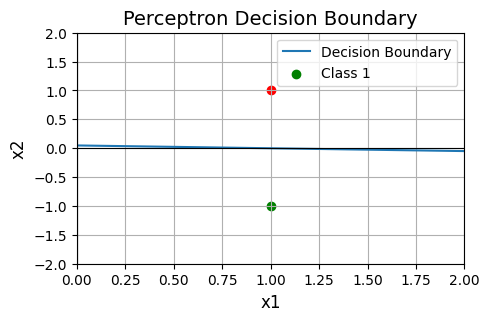

,Input,Predicted,True
0,"[1, -1]",[0.9708737885030443],1
1,"[1, 1]",[-0.972275000660705],-1


In [77]:
# Example 2 from the presentation:
# Data:
inputs = np.array([[1, -1], [1, 1]])
true_outputs = np.array([1, -1])
print_progress = True
learning_rate = 0.1
init_method = 'random'
adaptive_learning_rate = False
min_error = 0.0001
epochs = 15

# Train the linear neuron:
perceptron = LinearNeuron(inputs.shape[1], init_method)
perceptron.gradient_descent_iterative(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, print_progress)

# Print summary:
print(perceptron)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
error = perceptron_error(true_outputs, real_outputs)
print(f"Perceptron error: {error}")
print(f"MAE error: {MAE_error(true_outputs, real_outputs)}")
print(f"MSE error: {MSE_error(true_outputs, real_outputs)}")
plot_decision_boundary_2D(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}

df


- finetune parameters (learning rate, epochs):

In [78]:
# DataFrame to store the results for comparisons:
experiment_results_r = pd.DataFrame(columns=['MSE', 'MAE', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])
#np.random.seed(42)  # For reproducibility
inputs = np.array([[1, -1], [1, 1]])
true_outputs = np.array([1, -1])
data_description_orig = "Ex. 2"
variant = "iterative"

# Perceptron parameters:
adaptive_learning_rate = False
batch_size = 4
min_error = 0.0001
epochs = 100
learning_rate = 0.1
init_method = 'random'
print_progress = False
data_description = data_description_orig + " " + ("adaptive " if adaptive_learning_rate else "non-adaptive ") + str(min_error) + (str(batch_size) if variant == "batch" else "")

for learning_rate in [0.01, 0.1 , 1]:
    run_example_multiple_times(experiment_results_r, inputs, true_outputs, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, batch_size)

learning_rate = 0.1
for epochs in [2, 5, 10, 20]:
    run_example_multiple_times(experiment_results_r, inputs, true_outputs, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, batch_size)


print("\nExperiment Results:")
experiment_results_r


Experiment Results:


,MSE,MAE,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,1.673235e-02,1.290637e-01,100.0,0.006731,iterative,0.01,100,"[[-0.0044037548146005365], [-0.8798901621537175]]",6.658977e-03,Ex. 2 non-adaptive 0.0001
1,8.441013e-05,9.159227e-03,20.0,0.001119,iterative,0.10,100,"[[-0.04653890328441078], [-0.9904052394410625]]",4.734566e-02,Ex. 2 non-adaptive 0.0001
2,4.562461e+70,6.874005e+34,100.0,0.006416,iterative,1.00,100,"[[-4.0501130683101164e+30], [-7.84394854307704...",-4.050113e+30,Ex. 2 non-adaptive 0.0001
3,3.954489e-01,6.265378e-01,2.0,0.000137,iterative,0.10,2,"[[0.007252618271562747], [-0.3362198321402302]]",-5.190321e-02,Ex. 2 non-adaptive 0.0001
4,9.947980e-02,3.142302e-01,5.0,0.000310,iterative,0.10,5,"[[0.025976957620106635], [-0.6658949426757587]]",-7.969636e-03,Ex. 2 non-adaptive 0.0001
5,8.758975e-03,9.332774e-02,10.0,0.000624,iterative,0.10,10,"[[0.009194051968746939], [-0.9113017279633823]]",-8.364132e-03,Ex. 2 non-adaptive 0.0001
6,7.678271e-05,8.742134e-03,20.0,0.001112,iterative,0.10,20,"[[-0.028584913406306305], [-0.9917409411801512]]",2.838549e-02,Ex. 2 non-adaptive 0.0001


### Example 3: linear regression
- experiment with the noise levels and with the training parameters

Gradient Descent iterative:
Epoch: 0, MSE: 1.9645 Weights: [[0.17183189]] Bias: 1.7990578537188942 Learning rate: 0.0100
Epoch: 1, MSE: 1.0377 Weights: [[0.47250125]] Bias: 2.4915112261464625 Learning rate: 0.0100
Epoch: 2, MSE: 0.9931 Weights: [[0.72928346]] Bias: 2.759475796968919 Learning rate: 0.0100
Epoch: 3, MSE: 1.0750 Weights: [[0.92865316]] Bias: 2.8708506899106263 Learning rate: 0.0100
Epoch: 4, MSE: 1.1641 Weights: [[1.07736607]] Bias: 2.937062216625954 Learning rate: 0.0100
Epoch: 5, MSE: 1.2404 Weights: [[1.18445816]] Bias: 2.9696538815489717 Learning rate: 0.0100
Epoch: 6, MSE: 1.3035 Weights: [[1.26492684]] Bias: 2.9739644249926847 Learning rate: 0.0100
Epoch: 7, MSE: 1.3502 Weights: [[1.32182304]] Bias: 2.9987150121432364 Learning rate: 0.0100
Epoch: 8, MSE: 1.3888 Weights: [[1.36662429]] Bias: 2.9914358471047304 Learning rate: 0.0100
Epoch: 9, MSE: 1.4139 Weights: [[1.39515886]] Bias: 2.999678755821855 Learning rate: 0.0100
Epoch: 10, MSE: 1.4337 Weights: [[1.41725372]

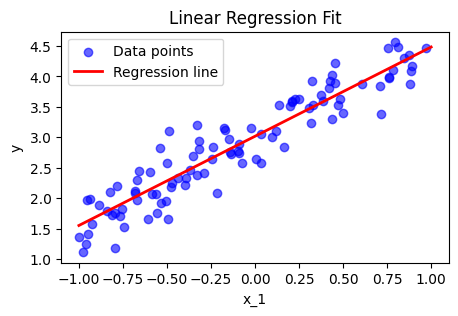

,Input,Predicted,True
0,[0.3305456724738216],[3.5028378389784627],[3.529855320727698]
1,[-0.8426028465849811],[1.7845031249682206],[1.7918470187933544]
2,[0.20751028767522595],[3.322625385639093],[3.587226886299168]
3,[-0.6721365580935945],[2.0341885964362643],[2.297472134886578]
4,[0.47190712103035604],[3.709892854035163],[3.529597419831034]
...,...,...,...
95,[0.7531209815774351],[4.1217925673183196],[4.459226935181698]
96,[-0.6834274878818039],[2.017650539836152],[2.082157178166621]
97,[-0.08867835689381609],[2.8887917988508245],[2.886334256518047]
98,[0.21139848091975133],[3.328320502087101],[3.5890609685126162]


In [79]:
# Example: linear regression
inputs, true_outputs = generate_regression_data_1D(A=1.5, B=3, std_noise=0.3, number_of_samples=100)

print_progress = True
learning_rate = 0.01
init_method = 'random'
adaptive_learning_rate = False
min_error = 0.0001
epochs = 15

# Train the linear neuron:
perceptron = LinearNeuron(inputs.shape[1], init_method)
perceptron.gradient_descent_iterative(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, print_progress)

# Print summary:
print(perceptron)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
error = perceptron_error(true_outputs, real_outputs)
print(f"Perceptron error: {error}")
print(f"MAE error: {MAE_error(true_outputs, real_outputs)}")
print(f"MSE error: {MSE_error(true_outputs, real_outputs)}")
plot_regression(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}

df


#### Example 3 and the batch variant of gradient descent
- experiment with the learning rate

Gradient Descent batch:
Epoch: 0, MSE: 0.4532 Weights: [[0.46757291]] Bias: 2.9752293195148862 Learning rate: 0.0100
Epoch: 1, MSE: 0.3141 Weights: [[0.70224898]] Bias: 2.9757189913412563 Learning rate: 0.0071
Epoch: 2, MSE: 0.2425 Weights: [[0.85283393]] Bias: 2.976035873160694 Learning rate: 0.0058
Epoch: 3, MSE: 0.1996 Weights: [[0.96044532]] Bias: 2.9762628776942273 Learning rate: 0.0050
Epoch: 4, MSE: 0.1718 Weights: [[1.04212326]] Bias: 2.9764353572771753 Learning rate: 0.0045
Epoch: 5, MSE: 0.1527 Weights: [[1.10658765]] Bias: 2.97657156095117 Learning rate: 0.0041
Epoch: 6, MSE: 0.1391 Weights: [[1.15889213]] Bias: 2.976682107130399 Learning rate: 0.0038
Epoch: 7, MSE: 0.1290 Weights: [[1.20221888]] Bias: 2.9767736964720415 Learning rate: 0.0035
Epoch: 8, MSE: 0.1214 Weights: [[1.23869454]] Bias: 2.976850812854077 Learning rate: 0.0033
Epoch: 9, MSE: 0.1156 Weights: [[1.26980563]] Bias: 2.97691659317024 Learning rate: 0.0032
Epoch: 10, MSE: 0.1111 Weights: [[1.29662847]] Bias: 

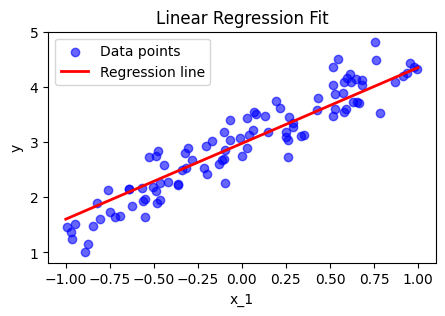

,Input,Predicted,True
0,[-0.9924646108989339],[1.612972922720742],[1.467796552687674]
1,[0.2627548727908584],[3.338300559126242],[3.0442969370144315]
2,[0.19303200139726173],[3.242464891764463],[3.739626056182298]
3,[-0.3636956283916799],[2.477230143494118],[2.214542577535086]
4,[-0.09715399279005932],[2.843597664180126],[2.8650021474139895]
...,...,...,...
95,[0.7613369251002968],[4.023612892979272],[4.492290811638393]
96,[-0.20551573706632964],[2.694651990090224],[2.924524833359239]
97,[-0.46259852849146355],[2.3412858651586648],[1.9434281226646255]
98,[-0.3048003710826981],[2.5581830098324416],[2.8976152417401564]


In [80]:
inputs, true_outputs = generate_regression_data_1D(A=1.5, B=3, std_noise=0.3, number_of_samples=100)

print_progress = True
learning_rate = 0.01
init_method = 'random'
adaptive_learning_rate = True
min_error = 0.0001
epochs = 15

# Train the linear neuron:
perceptron = LinearNeuron(inputs.shape[1], init_method)
perceptron.gradient_descent_batch(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, print_progress)

# Print summary:
print(perceptron)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
error = perceptron_error(true_outputs, real_outputs)
print(f"Perceptron error: {error}")
print(f"MAE error: {MAE_error(true_outputs, real_outputs)}")
print(f"MSE error: {MSE_error(true_outputs, real_outputs)}")
plot_regression(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}

df


- finetune parameters

In [81]:
# DataFrame to store the results for comparisons:
experiment_results_r = pd.DataFrame(columns=['MSE', 'MAE', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])
#np.random.seed(42)  # For reproducibility
inputs, true_outputs = generate_regression_data_1D(A=1.5, B=3, std_noise=0.3, number_of_samples=100)
data_description_orig = "regr. 1"
variant = "iterative"

# Perceptron parameters:
adaptive_learning_rate = False
batch_size = 4
min_error = 0.0001
epochs = 100
learning_rate = 0.1
init_method = 'random'
print_progress = False
data_description = data_description_orig + " " + ("adaptive " if adaptive_learning_rate else "non-adaptive ") + str(min_error) + (str(batch_size) if variant == "batch" else "")

for learning_rate in [0.01, 0.1 , 1]:
    run_example_multiple_times(experiment_results_r, inputs, true_outputs, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, batch_size)

learning_rate = 0.1
for epochs in [1, 2, 5, 10, 20]:
    run_example_multiple_times(experiment_results_r, inputs, true_outputs, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, batch_size)


print("\nExperiment Results:")
experiment_results_r


Experiment Results:


,MSE,MAE,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,1.757720,1.080279,100.0,0.217901,iterative,0.01,100,[[1.5850702950868627]],2.986726,regr. 1 non-adaptive 0.0001
1,1.750831,1.078385,100.0,0.170408,iterative,0.10,100,[[1.6035600483338222]],3.030133,regr. 1 non-adaptive 0.0001
2,2.122701,1.185124,100.0,0.146172,iterative,1.00,100,[[1.9017091474744794]],3.039538,regr. 1 non-adaptive 0.0001
3,1.714258,1.067360,1.0,0.001968,iterative,0.10,1,[[1.515966064872845]],3.033550,regr. 1 non-adaptive 0.0001
4,1.785865,1.088842,2.0,0.002834,iterative,0.10,2,[[1.5870331959169857]],2.985904,regr. 1 non-adaptive 0.0001
5,1.769538,1.083889,5.0,0.006354,iterative,0.10,5,[[1.5982222845438865]],2.965497,regr. 1 non-adaptive 0.0001
6,1.766867,1.083078,10.0,0.014487,iterative,0.10,10,[[1.5969086227654894]],3.003484,regr. 1 non-adaptive 0.0001
7,1.732031,1.072709,20.0,0.026597,iterative,0.10,20,[[1.598797591293249]],3.022307,regr. 1 non-adaptive 0.0001


In [82]:
# DataFrame to store the results for comparisons:
experiment_results_r = pd.DataFrame(columns=['MSE', 'MAE', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])
#np.random.seed(42)  # For reproducibility
inputs, true_outputs = generate_regression_data_1D(A=1.5, B=3, std_noise=0.3, number_of_samples=100)
data_description_orig = "regr. 1"
variant = "batch"

# Perceptron parameters:
adaptive_learning_rate = False
batch_size = 4
min_error = 0.0001
epochs = 100
learning_rate = 0.1
init_method = 'random'
print_progress = False
data_description = data_description_orig + " " + ("adaptive " if adaptive_learning_rate else "non-adaptive ") + str(min_error) + (str(batch_size) if variant == "batch" else "")

for learning_rate in [0.01, 0.1 , 1]:
    run_example_multiple_times(experiment_results_r, inputs, true_outputs, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, batch_size)

learning_rate = 0.1
for epochs in [1, 2, 5, 10, 20]:
    run_example_multiple_times(experiment_results_r, inputs, true_outputs, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, batch_size)


print("\nExperiment Results:")
experiment_results_r


Experiment Results:


<ipython-input-61-b1116fbba740>:227: RuntimeWarning: overflow encountered in square
  return np.mean((true_outputs - predicted_outputs) ** 2)
/usr/local/lib/python3.11/dist-packages/pandas/core/nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)
/usr/local/lib/python3.11/dist-packages/pandas/core/nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


,MSE,MAE,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,1.484495e+00,9.939446e-01,100.0,0.003702,batch,0.01,100,[[1.4214125484537523]],3.049665e+00,regr. 1 non-adaptive 0.00014
1,6.785571e+191,8.236002e+95,100.0,0.003877,batch,0.10,100,[[1.153390978861688e+94]],-8.246578e+95,regr. 1 non-adaptive 0.00014
2,inf,1.127195e+200,100.0,0.004031,batch,1.00,100,[[1.5960946123760863e+198]],-1.141184e+200,regr. 1 non-adaptive 0.00014
3,7.460365e+02,2.715236e+01,1.0,0.000074,batch,0.10,1,[[4.821527068374785]],3.020779e+01,regr. 1 non-adaptive 0.00014
4,5.945282e+04,2.437805e+02,2.0,0.000115,batch,0.10,2,[[-3.958360406253121]],-2.388681e+02,regr. 1 non-adaptive 0.00014
5,3.212080e+10,1.791844e+05,5.0,0.000218,batch,0.10,5,[[-2431.8146244199183]],1.839545e+05,regr. 1 non-adaptive 0.00014
6,1.096044e+20,1.046752e+10,10.0,0.000395,batch,0.10,10,[[144867801.90811637]],-1.035882e+10,regr. 1 non-adaptive 0.00014
7,1.351211e+39,3.675046e+19,20.0,0.000740,batch,0.10,20,[[5.0700253837515206e+17]],-3.624994e+19,regr. 1 non-adaptive 0.00014


### Example 4 - Linear regression with two input dimensions

Gradient Descent batch:
Epoch: 0, MSE: 23.7477 Weights: [[0.14695698 0.11395593]] Bias: -0.3753663236596718 Learning rate: 0.0010
Epoch: 1, MSE: 21.6877 Weights: [[0.19407011 0.16880704]] Bias: -0.6402182940939181 Learning rate: 0.0007
Epoch: 2, MSE: 20.2152 Weights: [[0.23086728 0.21332571]] Bias: -0.8411405366646413 Learning rate: 0.0006
Epoch: 3, MSE: 19.0712 Weights: [[0.26162639 0.25165962]] Bias: -1.0050766075987054 Learning rate: 0.0005
Epoch: 4, MSE: 18.1398 Weights: [[0.28832282 0.28575789]] Bias: -1.1443600637180904 Learning rate: 0.0004
Epoch: 5, MSE: 17.3578 Weights: [[0.31205616 0.31671963]] Bias: -1.2658120375015771 Learning rate: 0.0004
Epoch: 6, MSE: 16.6870 Weights: [[0.33351119 0.34523663]] Bias: -1.3736573991169871 Learning rate: 0.0004
Epoch: 7, MSE: 16.1021 Weights: [[0.35314772 0.37177771]] Bias: -1.470719587237587 Learning rate: 0.0004
Epoch: 8, MSE: 15.5857 Weights: [[0.37129175 0.39667806]] Bias: -1.5589916073938617 Learning rate: 0.0003
Epoch: 9, MSE: 15.1251 

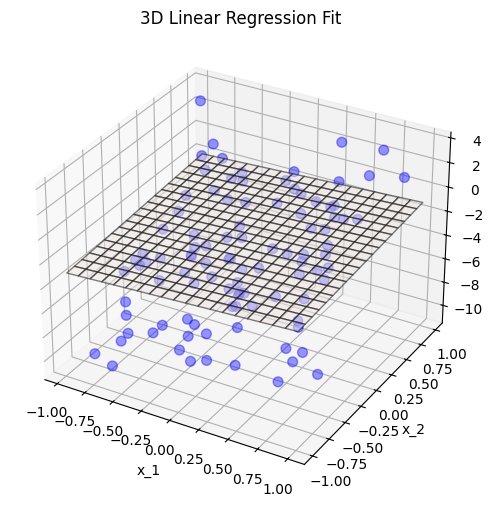

,Input,Predicted,True
0,"[0.239467736481622, 0.4209276940497275]",[-1.6367071994447315],[-1.350290118089421]
1,"[-0.9688575489089217, 0.10696253880683648]",[-2.3554670362209733],[-7.201917118229829]
2,"[0.15649822945474479, -0.39545598638988033]",[-2.1012484198794827],[-7.112053330988152]
3,"[0.07157455919209732, -0.23039314134273092]",[-2.054015053129359],[-5.4575614020512475]
4,"[0.11369723581698365, 0.2123083926578937]",[-1.803424963389141],[-3.6384942170469357]
...,...,...,...
95,"[0.03457124190481453, -0.643020674847339]",[-2.2865452287727868],[-6.7381995063887015]
96,"[-0.40837738044472083, -0.07396993136792829]",[-2.192656700908588],[-2.579073527568361]
97,"[0.6424132924653787, 0.06295991580296145]",[-1.6386995713559147],[-4.013909420369406]
98,"[0.4768933759436407, -0.9758650338142287]",[-2.2573358091936253],[-6.279466508906003]


In [83]:
# Define parameters
inputs, true_outputs = generate_regression_data_2D(A=2, B=3, C=-4, std_noise=2.5, number_of_samples=100)

# Train the linear neuron:
print_progress = True
learning_rate = 0.001
init_method = 'random'
adaptive_learning_rate = True
min_error = 0.0001
epochs = 15

# Train the linear neuron:
perceptron = LinearNeuron(inputs.shape[1], init_method)
perceptron.gradient_descent_batch(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, print_progress)

# Print summary:
print(perceptron)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
error = perceptron_error(true_outputs, real_outputs)
print(f"Perceptron error: {error}")
print(f"MAE error: {MAE_error(true_outputs, real_outputs)}")
print(f"MSE error: {MSE_error(true_outputs, real_outputs)}")
plot_regression_3D(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}

df



In [84]:
# DataFrame to store the results for comparisons:
experiment_results_r = pd.DataFrame(columns=['MSE', 'MAE', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])
#np.random.seed(42)  # For reproducibility
inputs, true_outputs = generate_regression_data_2D(A=2, B=3, C=-4, std_noise=2.5, number_of_samples=100)
data_description_orig = "regr. 2"
variant = "iterative"

# Perceptron parameters:
adaptive_learning_rate = False
batch_size = 4
min_error = 0.0001
epochs = 100
learning_rate = 0.1
init_method = 'random'
print_progress = False
data_description = data_description_orig + " " + ("adaptive " if adaptive_learning_rate else "non-adaptive ") + str(min_error) + (str(batch_size) if variant == "batch" else "")

for learning_rate in [0.001, 0.01, 0.1 , 1]:
    run_example_multiple_times(experiment_results_r, inputs, true_outputs, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, batch_size)

learning_rate = 0.01
for epochs in [1, 2, 5, 10, 20]:
    run_example_multiple_times(experiment_results_r, inputs, true_outputs, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, batch_size)


print("\nExperiment Results:")
experiment_results_r


Experiment Results:


,MSE,MAE,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,13.141747,2.905047,100.0,0.119860,iterative,0.001,100,"[[1.8114047776464774], [2.791887371140403]]",-3.839836,regr. 2 non-adaptive 0.0001
1,13.496553,2.945158,100.0,0.116631,iterative,0.010,100,"[[1.940535137496388], [2.9108193903869837]]",-3.838601,regr. 2 non-adaptive 0.0001
2,13.718867,2.967183,100.0,0.117050,iterative,0.100,100,"[[1.9161819445601458], [3.1236222768323465]]",-4.320125,regr. 2 non-adaptive 0.0001
3,50.554343,5.843930,100.0,0.133842,iterative,1.000,100,"[[4.556295692593636], [7.30892739591207]]",-0.968925,regr. 2 non-adaptive 0.0001
4,11.746239,2.777945,1.0,0.001163,iterative,0.010,1,"[[0.3912563914833976], [0.742613341391062]]",-2.408286,regr. 2 non-adaptive 0.0001
5,10.687787,2.625775,2.0,0.002420,iterative,0.010,2,"[[0.7749306911592909], [1.4384070795032196]]",-3.257925,regr. 2 non-adaptive 0.0001
6,11.996876,2.772167,5.0,0.006227,iterative,0.010,5,"[[1.4345423159178357], [2.3306635594983107]]",-3.826124,regr. 2 non-adaptive 0.0001
7,13.150875,2.906024,10.0,0.014196,iterative,0.010,10,"[[1.820718522958442], [2.786046134056912]]",-3.887654,regr. 2 non-adaptive 0.0001
8,13.462139,2.941256,20.0,0.023948,iterative,0.010,20,"[[1.9195757347384657], [2.892275512507851]]",-3.872223,regr. 2 non-adaptive 0.0001
